### 2.1 Ex. 1

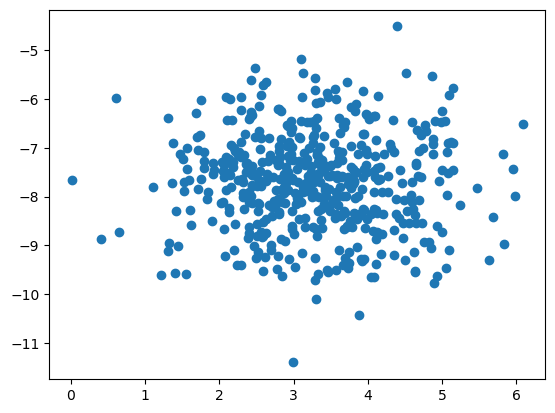

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np

X, y = make_blobs(n_samples=500, n_features=2, centers=1)
plt.scatter(X[:, 0], X[:, 1])

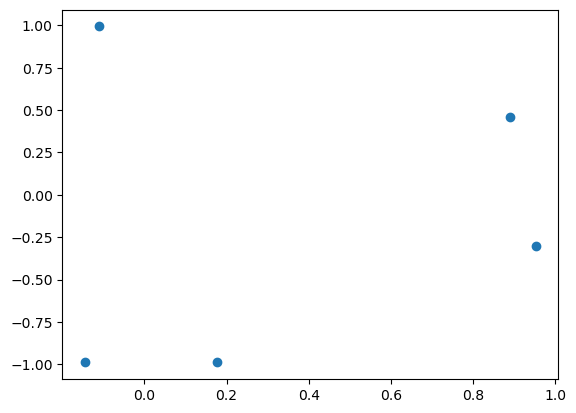

In [58]:
from numpy.random import multivariate_normal

proj_vectors = multivariate_normal(mean=[0, 0], cov=np.eye(2, 2), size=5)
proj_vectors = proj_vectors / np.expand_dims(np.linalg.norm(proj_vectors, axis=1), 1)
plt.scatter(proj_vectors[:, 0], proj_vectors[:, 1])

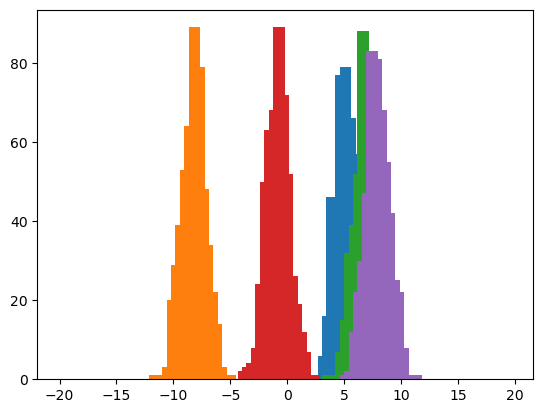

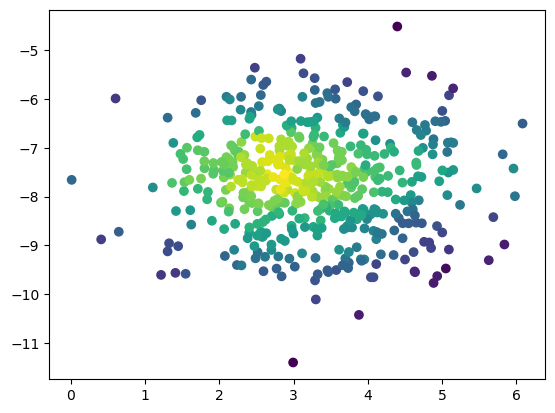

In [ ]:
# X_proj = np.expand_dims(X[:, 0], 1) * np.expand_dims(proj_vectors[:, 0], 0) + np.expand_dims(X[:, 1], 1) * np.expand_dims(proj_vectors[:, 1], 0)
X_proj = X @ proj_vectors.T
low = X_proj.min()
high = X_proj.max()
dist = high - low
low -= dist / 3
high += dist / 3
scores = []
for idx in range(5):
    projections = X_proj[:, idx]    
    hist, bin_edges = np.histogram(projections, bins=100, range=(low, high))
    probs = hist / np.sum(hist)
    indices = np.digitize(projections, bin_edges)
    scores.append(probs[indices])
    plt.bar(bin_edges[:-1], hist, width=1)
scores = np.vstack(scores).mean(axis=0)

threshold = np.quantile(scores, q=0.1)
is_outlier = scores < threshold
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=scores)

In [168]:
class LodaModel:
    def __init__(self, n_proj_vectors: int = 5, contamination: float = 0.1, n_bins: int = 100) -> None:
        self.n_proj_vectors = n_proj_vectors
        self.proj_vectors = multivariate_normal(mean=[0, 0], cov=np.eye(2, 2), size=n_proj_vectors)
        self.proj_vectors = self.proj_vectors / np.expand_dims(np.linalg.norm(self.proj_vectors, axis=1), 1)
        self.hists: list[np.ndarray] = []
        self.bin_edges: list[np.ndarray] = []
        self.probs: list[np.ndarray] = []
        self.contamination = contamination
        self.n_bins = n_bins

    def fit(self, X_train: np.ndarray) -> None:
        X_proj = X_train @ self.proj_vectors.T
        low = X_proj.min()
        high = X_proj.max()
        dist = high - low
        low -= dist / 3
        high += dist / 3
        for idx in range(self.n_proj_vectors):
            projections = X_proj[:, idx]    
            hist, bin_edges = np.histogram(projections, bins=self.n_bins, range=(low, high))
            self.probs.append(hist / np.sum(hist))
            self.hists.append(hist)
            self.bin_edges.append(bin_edges)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X_proj = X_test @ self.proj_vectors.T
        scores = []
        for idx in range(self.n_proj_vectors):
            projections = X_proj[:, idx]
            probs = self.probs[idx]
            bin_edges = self.bin_edges[idx]
            indices = np.digitize(projections, bin_edges)
            scores.append(probs[indices])
        scores = np.vstack(scores).mean(axis=0)

        return scores

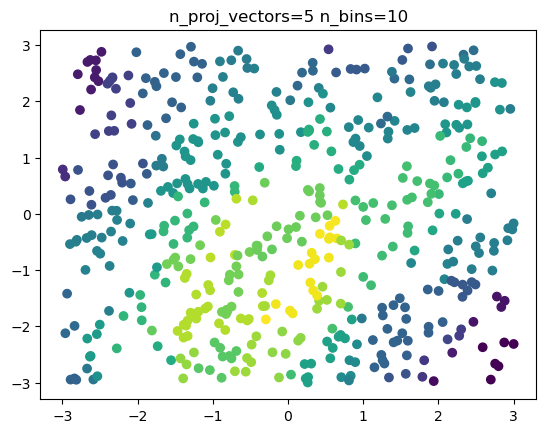

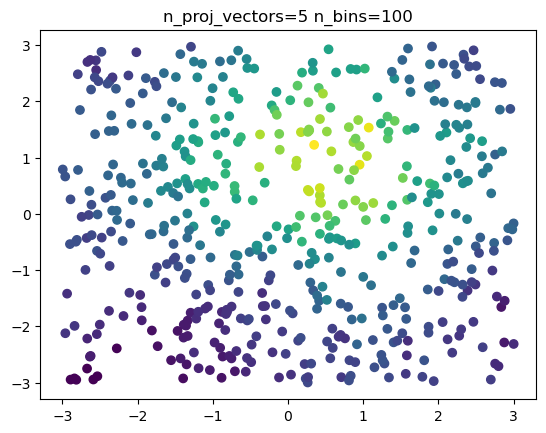

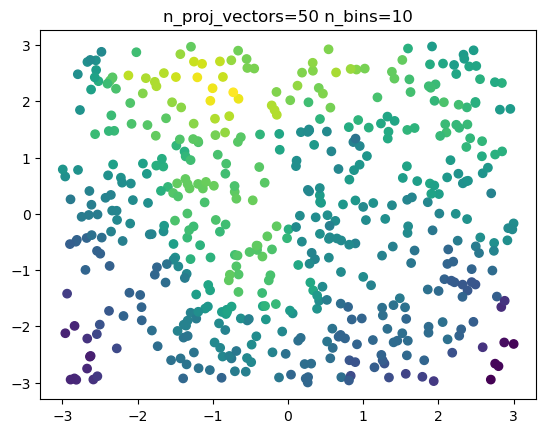

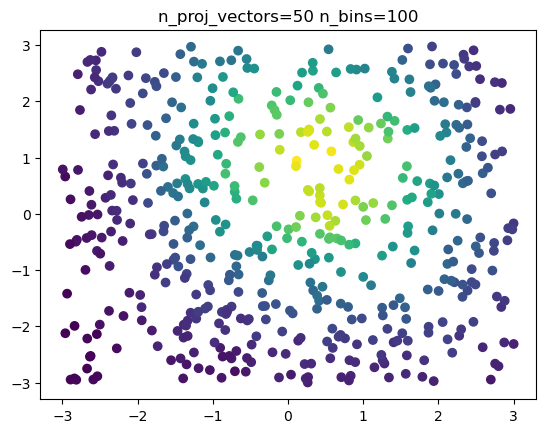

In [180]:
X_train, y_train = make_blobs(n_samples=500, n_features=2, centers=1, center_box=(-1, 1))
X_test = np.random.uniform(low=-3, high=3, size=(500, 2))

for n_proj_vectors, n_bins in zip([5, 5, 50, 50], [10, 100, 10, 100]):
    model = LodaModel(n_proj_vectors=n_proj_vectors, contamination=0.1, n_bins=n_bins)
    model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure()
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
    plt.title(f"n_proj_vectors={n_proj_vectors} n_bins={n_bins}")
    plt.savefig(f"plots/Ex 2.1 n_proj_vectors={n_proj_vectors} n_bins={n_bins}.jpg")